In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import datetime
import numpy as np

In [2]:
df = pd.read_csv('../META_1min_firstratedata.csv')

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['avg_price'] = (df['high'] + df['low']) / 2
df.set_index('timestamp', inplace=True)

trading_hours_df = df.between_time('09:30', '16:00').copy()

In [4]:
def calculate_all_daily_curves(df):
    # Ensure the index is a DatetimeIndex before proceeding
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("DataFrame index must be a DatetimeIndex.")

    grouped_by_day = trading_hours_df.groupby(trading_hours_df.index.date)

    daily_curves = {}

    # Iterate over each day's data group
    for date, daily_group in grouped_by_day:
        # Calculate the cumulative sum of volume for that day
        cumulative_vol = daily_group['volume'].cumsum()
        
        # Calculate the total volume for that day
        total_daily_vol = daily_group['volume'].sum()

        # Avoid division by zero on days with no volume
        if total_daily_vol > 0:
            # Calculate the cumulative percentage and store it in the dictionary
            volume_pct_curve = (cumulative_vol / total_daily_vol * 100).round(2)
            daily_curves[date] = volume_pct_curve
        else:
            # If there's no volume, store an empty Series
            daily_curves[date] = pd.Series(dtype=float)

    return daily_curves

In [5]:
def plot_daily_volume_curve(volume_curve_series, curve_date):
    # First, check if there is any data to plot.
    if volume_curve_series is None or volume_curve_series.empty:
        print(f"No data available to plot for {curve_date}. It may be a non-trading day.")
        return

    # Create the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Use the Series' built-in plot method, which is convenient
    volume_curve_series.plot(ax=ax, marker='.', linestyle='-', markersize=4, color='royalblue')

    # Formatting the plot for clarity
    ax.set_title(f'VWAP Benchmark Curve (Cumulative Volume) for {curve_date}', fontsize=16)
    ax.set_xlabel('Time of Day (HH:MM)')
    ax.set_ylabel('Cumulative Percentage of Daily Volume (%)')
    ax.set_ylim(0, 101)  # Set y-axis from 0% to 100%
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Format the y-axis to show a '%' sign
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
    
    fig.tight_layout()
    plt.show()

In [13]:
all_curves =calculate_all_daily_curves(trading_hours_df)

target_date_str = '2023-01-09'  
target_date_obj = datetime.datetime.strptime(target_date_str, '%Y-%m-%d').date()

specific_day_curve = all_curves.get(target_date_obj)

print(specific_day_curve)


timestamp
2023-01-09 09:30:00      1.70
2023-01-09 09:31:00      2.63
2023-01-09 09:32:00      3.24
2023-01-09 09:33:00      4.00
2023-01-09 09:34:00      4.41
                        ...  
2023-01-09 15:56:00     87.88
2023-01-09 15:57:00     88.34
2023-01-09 15:58:00     88.99
2023-01-09 15:59:00     90.44
2023-01-09 16:00:00    100.00
Name: volume, Length: 391, dtype: float64


### Step 1: Split Data into Training and Testing Sets

In [14]:
split_point = int(len(trading_hours_df.index.date) * 0.75)
train_dates = trading_hours_df.index.date[:split_point]
test_dates = trading_hours_df.index.date[split_point:]

train_df = trading_hours_df[trading_hours_df.index.to_series().dt.date.isin(train_dates)].copy()
test_df = trading_hours_df[trading_hours_df.index.to_series().dt.date.isin(test_dates)].copy()


### Step 2: Create the Historical Volume Profile (The "Training" Step)

In [16]:
def create_historical_profile(train_df):
    train_df['time'] = train_df.index.time
    
    # Calculate the average volume for each minute across all training days
    avg_volume_profile = train_df.groupby('time')['volume'].mean()
    historical_profile = avg_volume_profile / avg_volume_profile.sum()
    return historical_profile

In [19]:
historical_profile = create_historical_profile(train_df)

print("\nHistorical Volume Profile created from training data.")
print("First 5 minutes of the execution schedule:")
print((historical_profile * 100).round(4).astype(str) + '%')



Historical Volume Profile created from training data.
First 5 minutes of the execution schedule:
time
09:30:00      2.36%
09:31:00    0.7787%
09:32:00    0.6899%
09:33:00    0.6177%
09:34:00    0.5756%
             ...   
15:56:00    0.4563%
15:57:00    0.4965%
15:58:00     0.612%
15:59:00    1.3425%
16:00:00    8.6203%
Name: volume, Length: 391, dtype: object


### Step 3: Implement Backtesting and Evaluation

In [20]:
def simulate_vwap_execution(daily_df, historical_profile, total_shares_to_trade=1000000):
    if daily_df.empty:
        return float('nan')
    trade_schedule = historical_profile.reindex(daily_df.index.time).fillna(0)
    shares_per_minute = trade_schedule * total_shares_to_trade
    value_of_trades = (shares_per_minute * daily_df['avg_price']).sum()
    model_vwap = value_of_trades / total_shares_to_trade
    return model_vwap

In [21]:

def calculate_benchmark_vwap(daily_df):
    if daily_df.empty or daily_df['volume'].sum() == 0:
        return float('nan')
    vwap_numerator = (daily_df['avg_price'] * daily_df['volume']).sum()
    vwap_denominator = daily_df['volume'].sum()
    return vwap_numerator / vwap_denominator

In [26]:
def evaluate_vwap_strategy(test_df, historical_profile):
    # Group test data by day
    daily_groups = test_df.groupby(test_df.index.date)
    
    results = []
    
    for date, day_data in daily_groups:
        if len(day_data) == 0:
            continue
            
        # Calculate benchmark VWAP for the day
        benchmark_vwap = calculate_benchmark_vwap(day_data)
        
        # Ensure we have data for the day
        if day_data.empty or day_data['volume'].sum() == 0:
            continue
            
        # Get the time index for alignment
        time_index = day_data.index.time
        
        # Reindex the historical profile to match the day's timestamps
        trade_schedule = historical_profile.reindex(time_index).fillna(0)
        
        # Calculate shares to trade each minute
        shares_per_minute = trade_schedule * 1000000  # Total shares to trade
        
        # Calculate the total value of trades
        value_of_trades = (shares_per_minute * day_data['avg_price'].values).sum()
        
        # Calculate the model's VWAP
        model_vwap = value_of_trades / 1000000  # Divide by total shares
        
        # Calculate slippage
        if not pd.isna(benchmark_vwap) and not pd.isna(model_vwap):
            slippage = model_vwap - benchmark_vwap
            slippage_bps = (slippage / benchmark_vwap) * 10000  # in basis points
            
            results.append({
                'date': date,
                'benchmark_vwap': benchmark_vwap,
                'model_vwap': model_vwap,
                'slippage': slippage,
                'slippage_bps': slippage_bps
            })
    
    return pd.DataFrame(results)

In [27]:
results_df = evaluate_vwap_strategy(test_df, historical_profile)

Average Slippage: -55.18 bps
Standard Deviation of Slippage: 461.24 bps
Number of Days: 63

First few days of results:
         date  benchmark_vwap  model_vwap    slippage  slippage_bps
0  2023-07-03      286.615734  181.822031 -104.793703  -3656.243915
1  2023-07-05      294.739944  294.425197   -0.314747    -10.678817
2  2023-07-06      294.312300  294.076187   -0.236113     -8.022528
3  2023-07-07      292.001938  291.870977   -0.130961     -4.484928
4  2023-07-10      292.520569  292.486885   -0.033684     -1.151521


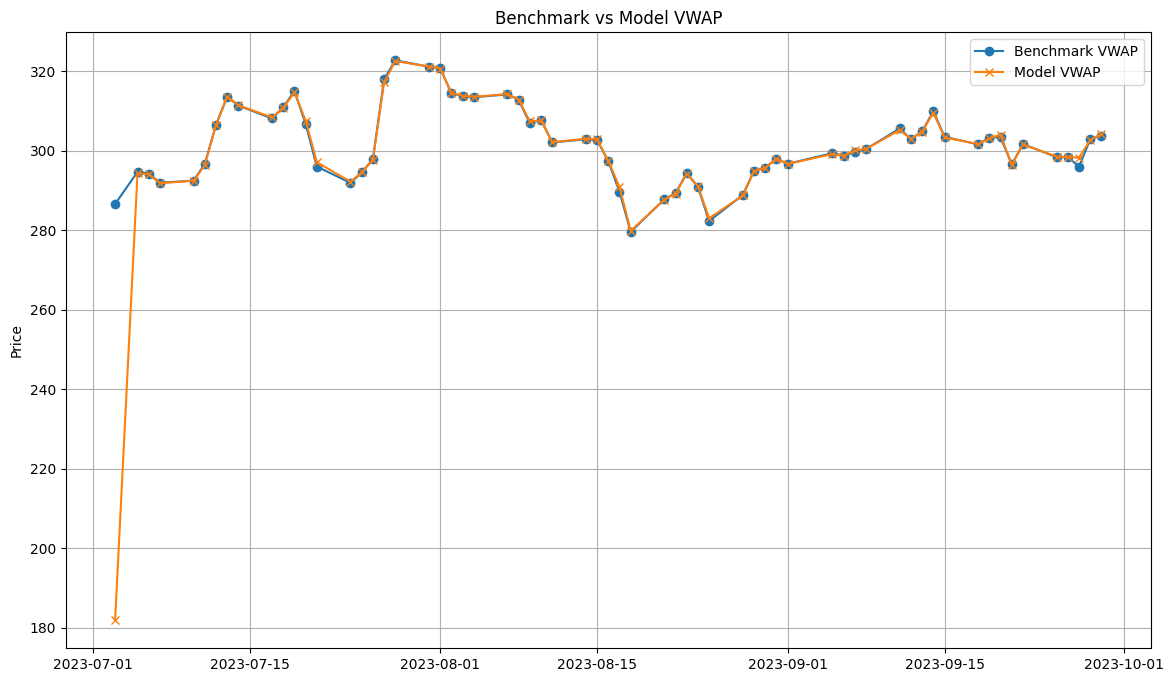

In [30]:
# Plot the results
plt.figure(figsize=(14, 8))

plt.plot(results_df['date'], results_df['benchmark_vwap'], label='Benchmark VWAP', marker='o')
plt.plot(results_df['date'], results_df['model_vwap'], label='Model VWAP', marker='x')
plt.title('Benchmark vs Model VWAP')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Calculate and print summary statistics
if not results_df.empty:
    avg_slippage_bps = results_df['slippage_bps'].mean()
    std_slippage_bps = results_df['slippage_bps'].std()
    print(f"Average Slippage: {avg_slippage_bps:.2f} bps")
    print(f"Standard Deviation of Slippage: {std_slippage_bps:.2f} bps")
    print(f"Number of Days: {len(results_df)}")
    print("\nFirst few days of results:")
    print(results_df.head())
else:
    print("No valid trading days found in the test set.")